# Firefly Algorithm

Firefly is a nature-inspired metaheuristic search algorithm. The idea is that the fireflies (the solutions) get attracted to the most luminous firefly (the best solution) and try to follow that solution. In reality, fireflies are actually repulsed by light, but for pedagogical reasons we assume that fireflies are attracted to luminous objects.

<style>
i {font-weight:normal}
span {font-weight:normal}
</style>

<div style="background-color: rgba(0,0,0,0.0470588);padding:10px;font-family:monospace;">
    <b>FIREFLY</b>(<i>source</i>,<i>destination</i>,<i>pop_size</i>, <i>num_iterations</i>) <b>return</b> a <i>route</i>
    <div style='padding-left:20px;'>
        generate <i>pop_size</i> random solutions/routes between <i>source</i> and <i>destination</i><br>
        for <i>num_iterations<i> do<br>
        <div style='padding-left:20px;'>
            for <i>i</i> in <i>pop_size</i> do:
            <div style='padding-left:20px;'>
                initialize <i><font color="green">attractiveness</font></i> for other fireflies relative to firefly <i>i</i><br>
                for <i>j</i> in <i>pop_size</i> do:
                <div style='padding-left:20px;'>
                    if <i>i</i> == <i>j</i>: continue <font color="#03a9f4">//skip itself</font><br>
                    <i><font color="green">attractiveness</font></i>[<i>j</i>] = <i><font color="orange">luminosity</font></i> of <i>j</i> relative to <i>i</i>
                </div>
                move <i>i</i> to the most luminous fly relative to it
            </div>
        </div>
        return the most luminous fly
    </div>
</div>
<br><br>

## Example: Routing problem and number of turns

We can once again solve the shortest path problem, but this time we can take into account a new cost dimension: the number of turns in the route.

While shorter routes are sometimes preferred, it is often the least complicated route that is preferred by drivers. This can be because simpler routes are both more time efficient (less turns means less delays, especially with left turns), but also that simpler routes are easier to navigate (less chance of making the wrong turn).

If we looks through the `osmnx` source code, we'll notice that it prunes nodes in ways that are topologically unimportant (for example, a midpoint node between two other nodes in a straight line). However, we may still have repeat nodes on an otherwise straight road segment (as nodes also mark intersections). We can get the number of roads traversed by counting unique roads (by their osmid).

Thus, our `luminosity` function will take into account both route length, as well as the complexity of the route. This should yield us results that are both simple as well as somewhat efficient.

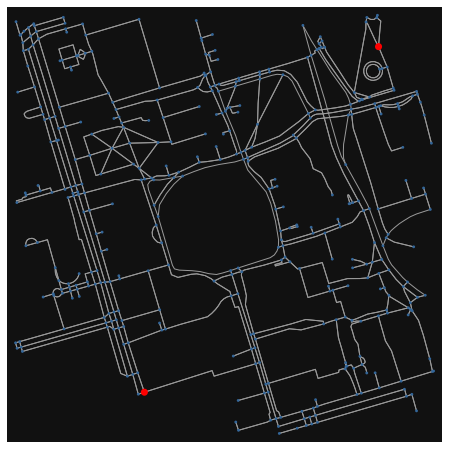

In [474]:
import osmnx
from smart_mobility_utilities.common import Node, cost, randomized_search
from smart_mobility_utilities.viz import draw_route
from smart_mobility_utilities.problem import cross_over
from tqdm.notebook import tqdm
import math
import matplotlib.pyplot as plt

reference = (43.661667, -79.395)

# The simplify=True is critical, as it removes non-important nodes
G = osmnx.graph_from_point(reference, dist=300, clean_periphery=True, simplify=True)

origin = Node(graph=G, osmid=55808290)
destination = Node(graph=G, osmid=389677909)

highlighted = [389677909, 55808290]

# marking both the source and destination node

nc = ['red' if node in highlighted else '#336699' for node in G.nodes()]
ns = [50 if node in highlighted else 8 for node in G.nodes()]
fig, ax = osmnx.plot_graph(G, node_size=ns, node_color=nc, node_zorder=2)

In [475]:
# Cost as length + complexity of route
def turns(G,route):
    roads = []
    for i in range(0,len(route)-1):
        way =G[route[i]][route[i+1]]
        roads.append(str(way[0]['osmid']))
    roads = len(set(roads))
    turn = roads -1
    return turn

def luminosity(G, route, k=1):
    
    return cost(G,route) + k*turns(G,route)

# Define the distance between two routes as the number of common nodes they possess
def distance(route1,route2):
    return len(set(route1) & set(route2))

In [476]:
# Initialize some parameters
num_of_iterations = 15
pop_size = 100
gamma = 2 # coefficient of attractiveness
k = 100 # weight for complexity, essentially how many metres does it cost per node

# Initialize starting population
flies = [randomized_search(G,origin.osmid, destination.osmid) for _ in range(pop_size)]

# Track performance
states= []

We can't simply have all flies move to the globally most luminous, as that simply converges all flies to the same fly within one iteration. Instead, we need luminosity to also be a function of distance.

$luminosity_i=luminosity_j \times e^{-\gamma \times distance}$

In [477]:
for _ in tqdm(range(num_of_iterations)):
    for i in range(pop_size):
        flies_luminosity = list()  # for all flies except i
        for j in range(pop_size):
            if i == j:
                continue
            flies_luminosity.append((j, luminosity(G, flies[j],k)))
        moving_fly = flies[i]
        # Using min here as the "most" luminous is the one with lowest cost + complexity
        target_fly = min(
            flies_luminosity,
            key=lambda fly: fly[1]
            * math.exp(-1 * gamma * distance(moving_fly, flies[fly[0]]))
        )
        target_fly = flies[target_fly[0]]
        # update the position, moving is just a crossover
        flies[i] = cross_over(target_fly,moving_fly)
    states.append(sum([luminosity(G,x,k) for x in flies]))

  0%|          | 0/15 [00:00<?, ?it/s]

In [478]:
# Most luminous fly
route = min(flies, key=lambda fly: luminosity(G,fly,k))
c = cost(G,route)
print("Cost:",c)
print("Number of turns:",turns(G,route))
draw_route(G,route)

Cost: 940.925
Number of turns: 8


Map(center=[43.6609405, -79.3951948], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_titl…

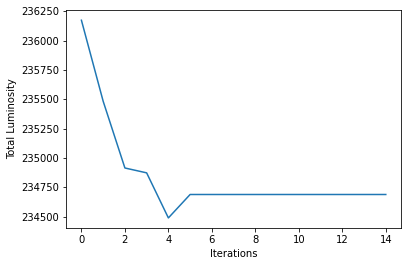

In [479]:
ax = plt.plot(states)
plt.xlabel('Iterations')
plt.ylabel('Total Luminosity')
plt.show()